<h1>Land cover classification of satellite imagery using Convolutional Neural Networks</h1>

The Salinas hyperspectral image was collected by the 224-band AVIRIS sensor over Salinas Valley, California. It is characterized by high spatial resolution (3.7-meter pixels). The area covered comprises 512 lines by 217 samples. This image was available only as at-sensor radiance data. It includes vegetables, bare soils, and vineyard fields. 

Download data from here: http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat

Inspired by https://github.com/syamkakarla98

<h3>Import Libraries</h3>

In [48]:
!pip install earthpy

In [49]:
!pip install plotly

In [50]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

<h3>Load Data</h3>

In [51]:
data = loadmat('Salinas_corrected.mat')['salinas_corrected']
gt = loadmat('Salinas_gt.mat')['salinas_gt']
print(f'Data Shape: {data.shape[0:2]}\nNumber of Bands: {data.shape[2]}')

Data Shape: (512, 217)
Number of Bands: 204


In [52]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df.head()

band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  ...  \
0    290    381    585   1041   1316   1397   1319   1462   1643    1683  ...   
1    290    381    519   1041   1316   1352   1319   1462   1643    1683  ...   
2    290    381    585   1041   1286   1352   1300   1412   1614    1644  ...   
3    290    381    585    999   1316   1374   1280   1380   1584    1631  ...   
4    219    381    585    999   1286   1352   1261   1396   1555    1618  ...   

   band196  band197  band198  band199  band200  band201  band202  band203  \
0       96      109       93       54       79       54       36       11   
1       94      111       96       56       83       56       36       11   
2       88      107       89       54       81       54       30       11   
3       86      105       85       56       75       50       30       11   
4       83      105       83       48       75       50       24        9   

   band204  class  
0       17      0  
1       15      0  
2       11      0  
3       19      0  
4       17      0  

[5 rows x 205 columns]

<h4>Description of Classes</h4>

1| Brocoli_green_weeds_1 |2009 2| Brocoli_green_weeds_2 |3726 3| Fallow |1976 4 |Fallow_rough_plow| 1394 5 |Fallow_smooth |2678 6| Stubble |3959 7 |Celery |3579 8 |Grapes_untrained |11271 9 |Soil_vinyard_develop| 6203 10| Corn_senesced_green_weeds| 3278 11| Lettuce_romaine_4wk |1068 12| Lettuce_romaine_5wk |1927 13| Lettuce_romaine_6wk |916 14| Lettuce_romaine_7wk |1070 15| Vinyard_untrained| 7268 16| Vinyard_vertical_trellis| 1807

<h3>Data Visualization</h3>

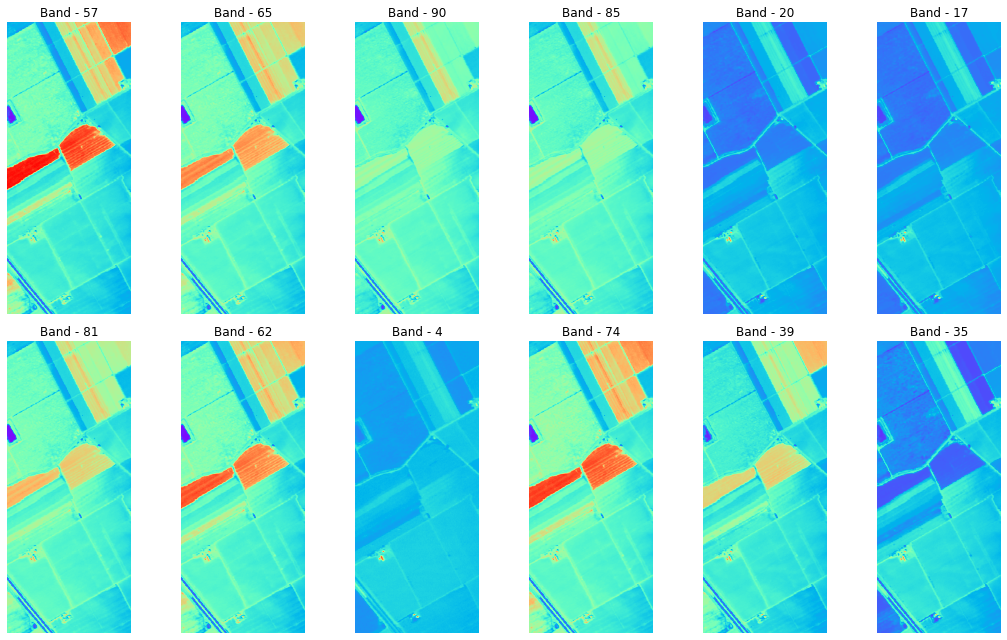

In [68]:
fig = plt.figure(figsize = (15, 9))

ax = fig.subplots(2, 6)

for i in range(2):
  for j in range(6):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='rainbow')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()

<h3>RGB Composite Image</h3>

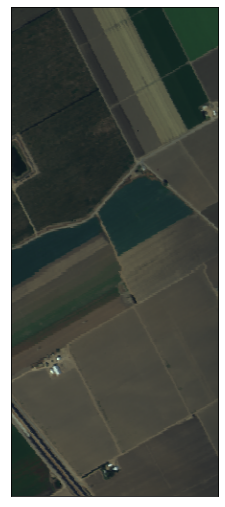

In [69]:
mdata = np.moveaxis(data, -1, 0)
ep.plot_rgb(mdata, (29, 19, 9), figsize=(15, 9)) 
plt.show()

<h3>GroundTruth Visualization</h3>

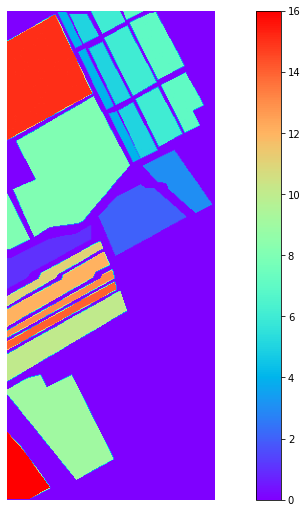

In [70]:
def plot_data(data):
  fig = plt.figure(figsize=(15, 9))
  plt.imshow(data, cmap='rainbow')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

<h3>Scaling data</h3>

In [10]:
t_df = df[df['class']!=0]
ind = ['band'+str(i) for i in range(1, t_df.shape[-1])]
X = t_df.loc[:, ind]
y = to_categorical(t_df.loc[:, 'class'])
X_scaled = minmax_scale(X, axis = 0);
X_scaled.shape, y.shape

((54129, 204), (54129, 17))

<h3>Split Data</h3>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}") 

X_train: (37890, 204)
y_train: (37890, 17)
X_test: (16239, 204)
y_test: (16239, 17)


<h3>Build CNN</h3>

In [12]:
ip_shape = X_train[1].shape
n_outputs = y_train.shape[1]
X_train[1].ravel().shape

(204,)

In [13]:
X_train = X_train.reshape(-1, 204, 1)
X_test = X_test.reshape(-1, 204, 1)

In [14]:
model = Sequential(name = 'Salinas_CNN')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

Model: "Salinas_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 202, 64)           256       
                                                                 
 Layer2 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 Layer3 (Conv1D)             (None, 198, 64)           12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 99, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 99, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 97, 32)            6176      
                                                       

2022-05-26 09:21:55.846540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ng1D)                                                           
                                                                 
 Dropout2 (Dropout)          (None, 46, 32)            0         
                                                                 
 Flatten (Flatten)           (None, 1472)              0         
                                                                 
 DenseLayer (Dense)          (None, 25)                36825     
                                                                 
 OutputLayer (Dense)         (None, 17)                442       
                                                                 
Total params: 74,611
Trainable params: 74,611
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [17]:
hist = model.fit(X_train, 
                 y_train, 
                 epochs = 100, 
                 batch_size = 256 , 
                 validation_data = (X_test, y_test), 
                 callbacks=[early_stop,
                            checkpoint,
                            tensorboard])

Epoch 1/100
149/149 [==============================] - 36s 237ms/step - loss: 1.4247 - accuracy: 0.5050 - val_loss: 0.8732 - val_accuracy: 0.6736
Epoch 2/100
149/149 [==============================] - 34s 230ms/step - loss: 0.5818 - accuracy: 0.7648 - val_loss: 0.5158 - val_accuracy: 0.8170
Epoch 3/100
149/149 [==============================] - 34s 228ms/step - loss: 0.4557 - accuracy: 0.8173 - val_loss: 0.4278 - val_accuracy: 0.8213
Epoch 4/100
149/149 [==============================] - 34s 231ms/step - loss: 0.3984 - accuracy: 0.8398 - val_loss: 0.3698 - val_accuracy: 0.8434
Epoch 5/100
149/149 [==============================] - 34s 226ms/step - loss: 0.3929 - accuracy: 0.8420 - val_loss: 0.5195 - val_accuracy: 0.7854
Epoch 6/100
149/149 [==============================] - 32s 215ms/step - loss: 0.3863 - accuracy: 0.8453 - val_loss: 0.3081 - val_accuracy: 0.8836
Epoch 7/100
149/149 [==============================] - 30s 203ms/step - loss: 0.3405 - accuracy: 0.8609 - val_loss: 0.2978 -

In [18]:
hist = pd.DataFrame(data= hist.history)
fig = go.Figure()
fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))
fig.show()

In [19]:
loss, acc = model.evaluate(X_test, y_test)

508/508 [==============================] - 4s 7ms/step - loss: 0.2238 - accuracy: 0.9078


In [20]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 90.78145027160645
Loss: 0.22384655475616455


In [21]:
from tensorflow.keras.models import load_model
model = load_model("Salinas_Model.h5")

In [22]:
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1.Brocoli_green_weeds_1',
                      '2.Brocoli_green_weeds_2',
                      '3.Fallow',
                      '4.Fallow_rough_plow',
                      '5.Fallow_smooth',
                      '6.Stubble',
                      '7.Celery',
                      '8.Grapes_untrained',
                      '9.Soil_vinyard_develop',
                      '10.Corn_senesced_green_weeds',
                      '11.Lettuce_romaine_4wk',
                      '12.Lettuce_romaine_5wk',
                      '13.Lettuce_romaine_6wk',
                      '14.Lettuce_romaine_7wk',
                      '15.Vinyard_untrained',
                      '16.Vinyard_vertical_trellis']))

                              precision    recall  f1-score   support

     1.Brocoli_green_weeds_1       0.97      1.00      0.98       584
     2.Brocoli_green_weeds_2       1.00      0.98      0.99      1137
                    3.Fallow       0.99      0.96      0.98       616
         4.Fallow_rough_plow       1.00      0.99      0.99       421
             5.Fallow_smooth       0.99      0.99      0.99       800
                   6.Stubble       1.00      1.00      1.00      1187
                    7.Celery       0.99      1.00      1.00      1067
          8.Grapes_untrained       0.89      0.77      0.82      3927
      9.Soil_vinyard_develop       1.00      0.99      0.99      1883
10.Corn_senesced_green_weeds       0.91      0.89      0.90      1010
      11.Lettuce_romaine_4wk       0.97      0.95      0.96       327
      12.Lettuce_romaine_5wk       1.00      0.97      0.99       595
      13.Lettuce_romaine_6wk       0.99      0.92      0.95       296
      14.Lettuce_ro

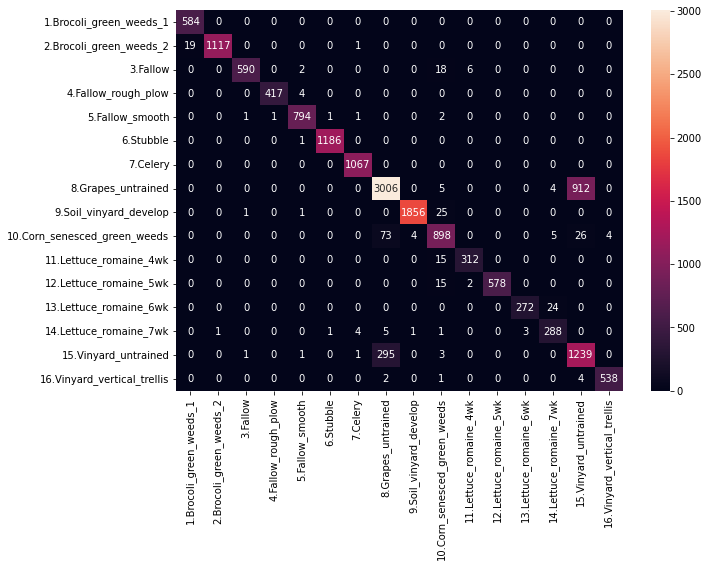

In [23]:
plt.figure(figsize = (10,7))

classes = ['1.Brocoli_green_weeds_1',
                      '2.Brocoli_green_weeds_2',
                      '3.Fallow',
                      '4.Fallow_rough_plow',
                      '5.Fallow_smooth',
                      '6.Stubble',
                      '7.Celery',
                      '8.Grapes_untrained',
                      '9.Soil_vinyard_develop',
                      '10.Corn_senesced_green_weeds',
                      '11.Lettuce_romaine_4wk',
                      '12.Lettuce_romaine_5wk',
                      '13.Lettuce_romaine_6wk',
                      '14.Lettuce_romaine_7wk',
                      '15.Vinyard_untrained',
                      '16.Vinyard_vertical_trellis']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))
df_cm = pd.DataFrame(mat, index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()